In [1]:
using Pkg

Pkg.activate(pwd())
Pkg.instantiate()
Pkg.status()

  Activating project at `~/codes/Julia/MyPack/ZetaReg`
Precompiling project...
   2394.2 ms  ✓ ZetaReg
  1 dependency successfully precompiled in 4 seconds. 608 already precompiled.


Project ZetaReg v0.1.0
Status `~/codes/Julia/MyPack/ZetaReg/Project.toml`
  [6e4b80f9] BenchmarkTools v1.6.0
  [336ed68f] CSV v0.10.15
  [324d7699] CategoricalArrays v0.10.8
  [a93c6f00] DataFrames v1.7.0
  [1313f7d8] DataFramesMeta v0.15.4
⌃ [31c24e10] Distributions v0.25.117
⌃ [48062228] FilePathsBase v0.9.23
⌅ [f6369f11] ForwardDiff v0.10.38
  [38e38edf] GLM v1.9.0
  [b964fa9f] LaTeXStrings v1.4.0
  [bdcacae8] LoopVectorization v0.12.172
  [add582a8] MLJ v0.20.7
⌃ [a7f614a8] MLJBase v1.7.0
⌅ [be38d6a3] Normalization v0.7.3
⌃ [91a5bcdd] Plots v1.40.9
  [08abe8d2] PrettyTables v2.4.0
  [8e980c4a] Shapefile v0.13.2
⌃ [276daf66] SpecialFunctions v2.5.0
  [56780e9a] StandardizedMatrices v0.3.0
⌃ [2913bbd2] StatsBase v0.34.4
  [3eaba693] StatsModels v0.7.4
  [f3b207a7] StatsPlots v0.15.7
  [a759f4b9] TimerOutputs v0.5.29
  [0004c1f4] TuringGLM v2.13.0
  [fdbf4ff8] XLSX v0.10.4
  [37e2e46d] LinearAlgebra v1.11.0
  [de0858da] Printf v1.11.0
  [9a3f8284] Random v1.11.0
  [8dfed614] Test v1.1

In [2]:
using CSV, DataFrames, StatsBase, Plots, SpecialFunctions, Printf
using BenchmarkTools, LinearAlgebra, Distributions, Random, StatsModels, GLM
using ZetaReg


# Census Data in USA

In [3]:
# using DataFrames
state_data = DataFrame(
    STATE = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
             24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 
             42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56],
    Division = [
        "East South Central", "Pacific", "Mountain", "West South Central", "Pacific", "Mountain", 
        "New England", "South Atlantic", "South Atlantic", "South Atlantic", "South Atlantic", 
        "Pacific", "Mountain", "East North Central", "East North Central", "West North Central", 
        "West North Central", "East South Central", "West South Central", "New England", 
        "South Atlantic", "New England", "East North Central", "West North Central", 
        "East South Central", "West North Central", "Mountain", "West North Central", 
        "Mountain", "New England", "Middle Atlantic", "Mountain", "Middle Atlantic", 
        "South Atlantic", "West North Central", "East North Central", "West South Central", 
        "Pacific", "Middle Atlantic", "New England", "South Atlantic", "West North Central", 
        "East South Central", "West South Central", "Mountain", "New England", "South Atlantic", 
        "Pacific", "South Atlantic", "East North Central", "Mountain"
    ]
)

division_mapping = Dict(
    "New England" => 1,
    "Middle Atlantic" => 2,
    "East North Central" => 3,
    "West North Central" => 4,
    "South Atlantic" => 5,
    "East South Central" => 6,
    "West South Central" => 7,
    "Mountain" => 8,
    "Pacific" => 9
)

state_data.DivisionCode = [division_mapping[d] for d in state_data.Division];


In [4]:
Population = CSV.read("src/datasets/Population.csv", DataFrame)
GDP = CSV.read("src/datasets/GDP.csv", DataFrame)
Area = CSV.read("src/datasets/Area.csv", DataFrame)

Population_gdp_area_data = leftjoin(leftjoin(Population, GDP, on = :GeoFips), Area, on = :GeoFips)

data1 = Population_gdp_area_data
rename!(data1, Symbol("FIPS State Code") => :FIPS_State_Code)
data1 = data1 |>
    dp -> filter(row -> row.GDP2010 !== missing && row.Population2010 !== missing && row.ALAND !== missing, dp) |>
    dp -> select(dp, [:GeoFips, :FIPS_State_Code, :Population2010, :ALAND, :GDP2010])

data = copy(data1)

size1 = 5e4
data.Population2010 = ceil.(data.Population2010 ./size1)
data.DivisionCode = [state_data[findall(state_data.STATE .== d),2][1] for d in data.FIPS_State_Code]

categories = unique(data.DivisionCode)
for category in categories
    data[!, category] = ifelse.(data.DivisionCode .== category, 1, 0)
end

data = select!(data, Not(1,2,6,9))
data = Float64.(data)
W = Matrix(data[:,2:end])
W = Float64.(coalesce.(W, 0.0))
W = ZetaReg.StandardizeColumns(W)
data[:,2:end] = W
data

Z = data.Population2010;


Fitting with the Zeta Distribution:
The 1 steps with infinity norm: 579.8077953028693 Log-likelihood: -4010.494534663105
The 2 steps with infinity norm: 194.85051898114102 Log-likelihood: -3996.148557131718
The 3 steps with infinity norm: 175.15551337398836 Log-likelihood: -3989.193700686734
The 4 steps with infinity norm: 166.34679698847663 Log-likelihood: -3985.764979734699
The 5 steps with infinity norm: 162.17535264464095 Log-likelihood: -3984.062035301947
The 6 steps with infinity norm: 160.14483720201216 Log-likelihood: -3983.8493622305778
The 7 steps with infinity norm: 159.8931226790466 Log-likelihood: -3983.8227810395056
The 8 steps with infinity norm: 159.86169093421188 Log-likelihood: -3983.8094911118587
The 9 steps with infinity norm: 159.84597833256916 Log-likelihood: -3983.8028463149626
The 10 steps with infinity norm: 159.8381228492752 Log-likelihood: -3983.7995239582397
Converged at the 10 steps with infinity norm: 159.8381228492752
Zeta Mean Model Summary:
\begin{tabul

The 40 steps with infinity norm: 0.1966914668307958 Log-likelihood: -3720.2110348887913
The 41 steps with infinity norm: 0.16656959780428413 Log-likelihood: -3720.2110092739895
The 42 steps with infinity norm: 0.1410603275055317 Log-likelihood: -3720.210988760289
The 43 steps with infinity norm: 0.11945958880709939 Log-likelihood: -3720.2109721373877
The 44 steps with infinity norm: 0.1011628805083191 Log-likelihood: -3720.210958728114
The 45 steps with infinity norm: 0.08567290062171924 Log-likelihood: -3720.2109477874724
The 46 steps with infinity norm: 0.07255443902349897 Log-likelihood: -3720.210938803003
The 47 steps with infinity norm: 0.061443528883092714 Log-likelihood: -3720.2109313988803
The 48 steps with infinity norm: 0.052033502479643605 Log-likelihood: -3720.2109253266717
The 49 steps with infinity norm: 0.04406696532228553 Log-likelihood: -3720.210920306946
The 50 steps with infinity norm: 0.037320721270060454 Log-likelihood: -3720.210916205206
The 51 steps with infinity

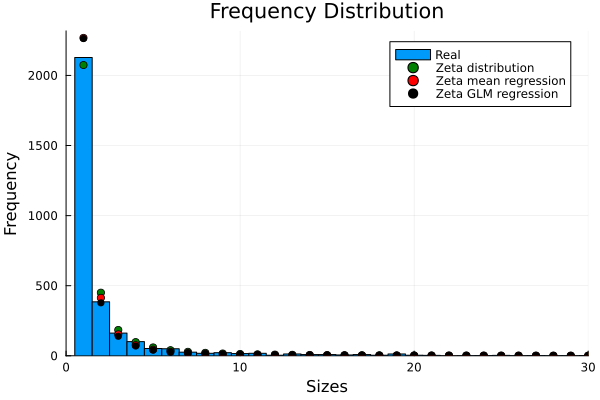

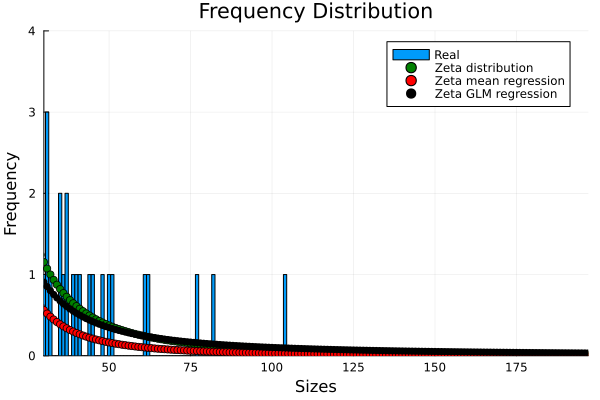

In [5]:
println("Fitting with the Zeta Distribution:")
println("==============================================")

## MLE of Zeta distribution without covariates

W = Matrix(data[:,2:end])
Z = data[:,1]

n = length(Z)
n0 = Int(maximum(Z))
x = range(1,n0,n0) 
θ0 = ZetaReg.Rootθ(sum(log.(Z))/n)
fit0 = (x.^(-θ0))./zeta(θ0) * n

LogLik0 = ZetaLogLik(θ0, log.(Z), 1)
(rho2, θ2, iters2, loglikelihoods2) = ZetaMeanModel(data, verbose=true)
(rho3, θ3, iters3, loglikelihoods3) = ZetaMeanLogModel(data, verbose=true)


println("θ0: ", θ0)
println("LogLik0: ", LogLik0)
println("LogLik2: ", loglikelihoods2[end], "Iterations: ",  iters2)
println("LogLik3: ", loglikelihoods3[end], "Iterations: ",  iters3)

x1 = range(1,n0,n0) 
fit2 = zeros(n0)
# fit1 = zeros(n0)
fit3 = zeros(n0)

for l in range(1, n, n)
    l = Int64(l)
    theta2 = θ2[l]
    fit2 = fit2 + (x1.^(-theta2))./zeta(theta2)
    theta3 = θ3[l]
    fit3 = fit3 + (x1.^(-theta3))./zeta(theta3)
end

p1 = plot()

histogram!(p1, Z, ylim = (0,max(fit0[1],fit2[1],fit3[1])+50), bins=0.5:(n0-0.5), xlim=(0, 30), label = "Real" , xlabel="Sizes", ylabel="Frequency", title="Frequency Distribution")
plot!(p1, x, fit0, label = "Zeta distribution", color = "green", seriestype=:scatter)
plot!(p1, x, fit2, label = "Zeta mean regression", color = "red", seriestype=:scatter)
plot!(p1, x, fit3, label = "Zeta GLM regression", color = "black", seriestype=:scatter)

display(p1)

# savefig(p1,"/Users/caleblee/Downloads/Zeta mean log reg/Frequency.pdf")

p2 = plot()
histogram!(p2, Z, ylim = (0,4), bins=0.5:(n0-0.5), xlim=(30, n0), label = "Real" , xlabel="Sizes", ylabel="Frequency", title="Frequency Distribution")
plot!(p2, x, fit0, label = "Zeta distribution", color = "green", seriestype=:scatter)
plot!(p2, x, fit2, label = "Zeta mean regression", color = "red", seriestype=:scatter)
plot!(p2, x, fit3, label = "Zeta GLM regression", color = "black", seriestype=:scatter)


display(p2)

## Negative Binomial regression model

In [6]:
using DataFrames, StatsModels, GLM, Distributions

yvar = :Population2010
xvars = names(data)
deleteat!(xvars, findfirst(==(string(yvar)), xvars))  # remove x1 from xvars

fmla = Term(yvar) ~ sum(Term.(Symbol.(xvars)))       
gm = glm(fmla, data, NegativeBinomial(4.0), LogLink(), maxiter = 100)
println("Loglikelihood: ", loglikelihood(gm))
gm


Loglikelihood: -5100.396120022678


StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, NegativeBinomial{Float64}, LogLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int32}}}}, Matrix{Float64}}

Population2010 ~ 1 + ALAND + GDP2010 + East South Central + Pacific + West South Central + New England + South Atlantic + East North Central + West North Central + Middle Atlantic

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                          Coef.  Std. Error       z  Pr(>|z|)   Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
(Intercept)          0.617807    0.0118895    51.96    <1e-99   0.594504    0.64111
ALAND               -0.0208615   0.0135502    -1.54    0.1237  -0.0474194   0.00569646
GDP2010              0.742352    0.00703045  105.59    <1e-99   0.728573    0.756132
East South Central  -0.0316532   0.0176928    -1.79    0.0736

# Covid data in Africa

In [7]:
covid = CSV.read("src/datasets/covid19.csv", DataFrame);

In [8]:
data = deepcopy(covid)
data = select(data, [:Deaths, :Population, :capital, :continent])
size1 = 1e3
data.Deaths = ceil.(data.Deaths ./size1)

data = dropmissing(data, names(data)[1])
data = dropmissing(data, names(data)[2])

continents = unique(data.continent)
for c in continents
    colname = Symbol(c)
    data[!, colname] = [cont == c ? 1 : 0 for cont in data.continent]
end

# select!(data, Not(:continent, :"North America"))
select!(data, Not(:continent, :Asia))
data = Float64.(data)

W = Matrix(data[:,2:end])
W = Float64.(coalesce.(W, 0.0))
W = ZetaReg.StandardizeColumns(W)
data[:,2:end] = W
data
Z = data.Deaths;



Fitting with the Zeta Distribution:
The 1 steps with infinity norm: 109.68942961530193 Log-likelihood: -820.0162876586776
The 2 steps with infinity norm: 10.958214866832625 Log-likelihood: -819.070407258356
The 3 steps with infinity norm: 10.068393299578215 Log-likelihood: -818.6356696816598
The 4 steps with infinity norm: 9.659271122534264 Log-likelihood: -818.4264477512676
The 5 steps with infinity norm: 9.462480586243974 Log-likelihood: -818.3237188688269
The 6 steps with infinity norm: 9.365896343769437 Log-likelihood: -818.3109521670581
The 7 steps with infinity norm: 9.353897057617802 Log-likelihood: -818.3045758215508
The 8 steps with infinity norm: 9.347904192345112 Log-likelihood: -818.3029824066487
The 9 steps with infinity norm: 9.34640663571178 Log-likelihood: -818.3025840948433
The 10 steps with infinity norm: 9.346032287742856 Log-likelihood: -818.3023849457583
The 11 steps with infinity norm: 9.345845120357327 Log-likelihood: -818.3022853729202
The 12 steps with infinity

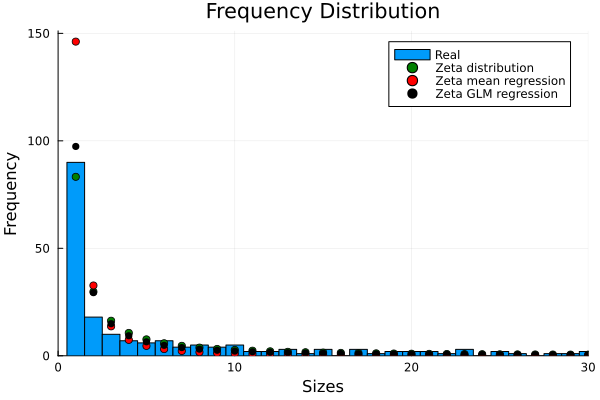

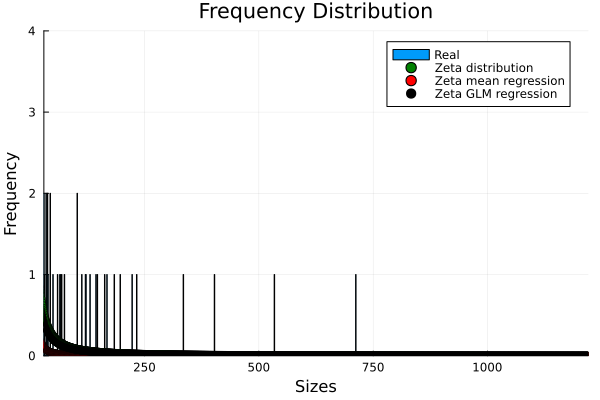

In [9]:
println("Fitting with the Zeta Distribution:")
println("==============================================")

## MLE of Zeta distribution without covariates

n = length(Z)
n0 = Int(maximum(Z))
x = range(1,n0,n0) 
θ0 = ZetaReg.Rootθ(sum(log.(Z))/n)
fit0 = (x.^(-θ0))./zeta(θ0) * n

LogLik0 = ZetaLogLik(θ0, log.(Z), 1)

## MLEs of Zeta regression models
(rho2, θ2, iters2, loglikelihoods2) = ZetaMeanModel(data, tol=1e-8, verbose=true)
(rho3, θ3, iters3, loglikelihoods3) = ZetaMeanLogModel(data, verbose=true)


println("θ0: ", θ0)
println("LogLik0: ", LogLik0)
# println("LogLik1: ", loglikelihoods1[end], "Iterations: ",  iters1)
println("LogLik2: ", loglikelihoods2[end], "Iterations: ",  iters2)
println("LogLik3: ", loglikelihoods3[end], "Iterations: ",  iters3)

x1 = range(1,n0,n0) 
fit2 = zeros(n0)
# fit1 = zeros(n0)
fit3 = zeros(n0)

for l in range(1, n, n)
    l = Int64(l)
#     theta1 = θ1[l]
#     fit1 = fit1 + (x1.^(-theta1))./zeta(theta1)
    theta2 = θ2[l]
    fit2 = fit2 + (x1.^(-theta2))./zeta(theta2)
    theta3 = θ3[l]
    fit3 = fit3 + (x1.^(-theta3))./zeta(theta3)
end


# 绘制图形
p1 = plot()

histogram!(p1, Z, ylim = (0,max(fit0[1],fit2[1],fit3[1])+5), bins=0.5:(n0-0.5), xlim=(0, 30), label = "Real" , xlabel="Sizes", ylabel="Frequency", title="Frequency Distribution")
plot!(p1, x, fit0, label = "Zeta distribution", color = "green", seriestype=:scatter)
plot!(p1, x, fit2, label = "Zeta mean regression", color = "red", seriestype=:scatter)
plot!(p1, x, fit3, label = "Zeta GLM regression", color = "black", seriestype=:scatter)

# 显示图形
display(p1)

# savefig(p1,"/Users/caleblee/Downloads/Zeta mean log reg/Frequency.pdf")

# 绘制图形
p2 = plot()
histogram!(p2, Z, ylim = (0,4), bins=0.5:(n0-0.5), xlim=(30, n0), label = "Real" , xlabel="Sizes", ylabel="Frequency", title="Frequency Distribution")
plot!(p2, x, fit0, label = "Zeta distribution", color = "green", seriestype=:scatter)
# plot!(p2, x, fit1, label = "Quadratic distance estimation", color = "yellow", seriestype=:scatter)
plot!(p2, x, fit2, label = "Zeta mean regression", color = "red", seriestype=:scatter)
plot!(p2, x, fit3, label = "Zeta GLM regression", color = "black", seriestype=:scatter)

# 显示图形
display(p2)
# 

# savefig(p2,"/Users/caleblee/Downloads/Zeta mean log reg/fittedTail.pdf")

## Negative Binomial regression model

In [10]:
using DataFrames, StatsModels, GLM, Distributions

yvar = :Deaths
xvars = names(data)
deleteat!(xvars, findfirst(==(string(yvar)), xvars))  

fmla = Term(yvar) ~ sum(Term.(Symbol.(xvars)))       
gm = glm(fmla, data, NegativeBinomial(0.7), LogLink(), maxiter = 100)
println("Loglikelihood: ", loglikelihood(gm))
gm

Loglikelihood: -775.578547726474


StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, NegativeBinomial{Float64}, LogLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int32}}}}, Matrix{Float64}}

Deaths ~ 1 + Population + capital + Europe + Africa + North America + South America + Oceania

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)     2.44894     0.106865  22.92    <1e-99   2.23948    2.65839
Population      2.46243     0.105275  23.39    <1e-99   2.2561     2.66877
capital        -0.134975    0.121006  -1.12    0.2647  -0.372143   0.102192
Europe          0.455949    0.143659   3.17    0.0015   0.174383   0.737516
Africa         -0.435654    0.143973  -3.03    0.0025  -0.717835  -0.153472
North America  -0.150219    0.13504   -1.11    0.2660  

# Crimes in the major cities in USA

In [11]:
report = CSV.read("src/datasets/report.csv", DataFrame)
data = deepcopy(report)
data = select(data, [:homicides, :report_year, :city, :population])
data = rename(data, :report_year => :Year)
data = rename(data, :population => :Population)
data = rename(data, :homicides => :Homicides)
data = rename(data, :city => :City)

histogram(data.Homicides)
size1 = 1e2
data.Homicides = ceil.(data.Homicides ./size1)
data = filter(row -> !ismissing(row.Homicides), data)

categories = unique(data.City)
for category in categories
    data[!, category] = ifelse.(data.City .== category, 1, 0)
end

data = select!(data, Not(3, 5, 6)) # remove TX city
data = dropmissing(data, names(data)[1])
data = Float64.(data)

W = Matrix(data[:,2:end])
W = Float64.(coalesce.(W, 0.0))
W = ZetaReg.StandardizeColumns(W)

Z = data.Homicides;
clean_iter = skipmissing(Z)
Z = collect(clean_iter);

data[:,2:end] = W
data;



The 1 steps with infinity norm: 411.98573765780975 Log-likelihood: -2903.1710362106196
The 2 steps with infinity norm: 113.75635083457125 Log-likelihood: -2825.4422013613876
The 3 steps with infinity norm: 96.17866303715905 Log-likelihood: -2814.381667334026
The 4 steps with infinity norm: 91.82795294088523 Log-likelihood: -2808.7802343650255
The 5 steps with infinity norm: 89.4459718003477 Log-likelihood: -2805.9598614991355
The 6 steps with infinity norm: 88.20038255207187 Log-likelihood: -2805.604862094669
The 7 steps with infinity norm: 88.04127813294606 Log-likelihood: -2805.5160449461137
The 8 steps with infinity norm: 88.0013918601271 Log-likelihood: -2805.4716309269256
The 9 steps with infinity norm: 87.98143460459434 Log-likelihood: -2805.449422551696
The 10 steps with infinity norm: 87.9714524448674 Log-likelihood: -2805.438318024418
The 11 steps with infinity norm: 87.9664604817108 Log-likelihood: -2805.436929919571
Converged at the 11 steps with infinity norm: 87.9664604817

The 9 steps with infinity norm: 0.27613968599971467 Log-likelihood: -2622.3647358768835
The 10 steps with infinity norm: 0.09385987717937694 Log-likelihood: -2622.3123928699397
The 11 steps with infinity norm: 0.031906459208545575 Log-likelihood: -2622.2930967343277
The 12 steps with infinity norm: 0.010870717730640673 Log-likelihood: -2622.2859893041405
The 13 steps with infinity norm: 0.0037117329985553718 Log-likelihood: -2622.283371992611
The 14 steps with infinity norm: 0.0013813541342303482 Log-likelihood: -2622.282408999036
Converged at the 14 steps with infinity norm: 0.0013813541342303482
Zeta Mean Log Model Summary:
\begin{tabular}{rrrrrr}
  \toprule
  \textbf{Parameter} & \textbf{Estimate} & \textbf{StandardError} & \textbf{WaldStatistic} & \textbf{CI\_95} & \textbf{p\_value} \\
  \texttt{String} & \texttt{String} & \texttt{String} & \texttt{String} & \texttt{String} & \texttt{String} \\\midrule
  Intercept &  -3.7840 &   0.0428 & 7805.2971 & ( -3.8680,  -3.7001) & 0.00e+00 

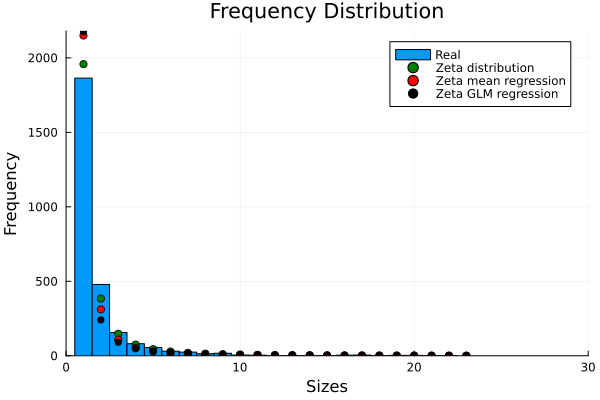

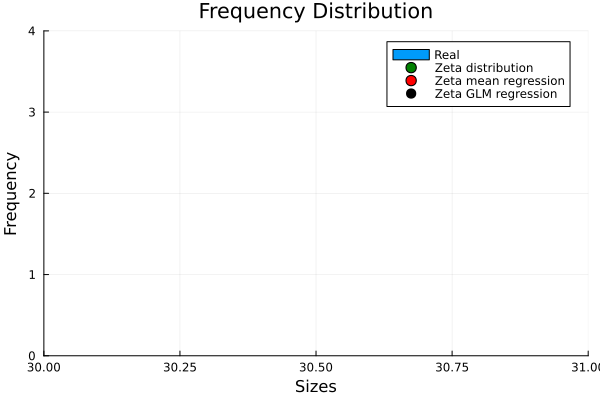

In [12]:
### println("Fitting with the Zeta Distribution:")
println("==============================================")

## MLE of Zeta distribution without covariates

n = length(Z)
n0 = Int(maximum(Z))
x = range(1,n0,n0) 
θ0 = ZetaReg.Rootθ(sum(log.(Z))/n)
fit0 = (x.^(-θ0))./zeta(θ0) * n

LogLik0 = ZetaLogLik(θ0, log.(Z), 1)

## MLEs of Zeta regression models
(rho2, θ2, iters2, loglikelihoods2, BIC2, df2) = ZetaMeanModel(data, verbose=true)
(rho3, θ3, iters3, loglikelihoods3, BIC3, df3) = ZetaMeanLogModel(data, verbose=true)


println("θ0: ", θ0)
println("LogLik0: ", LogLik0)
println("LogLik2: ", loglikelihoods2[end], "Iterations: ",  iters2)
println("LogLik3: ", loglikelihoods3[end], "Iterations: ",  iters3)

x1 = range(1,n0,n0) 
fit2 = zeros(n0)
# fit1 = zeros(n0)
fit3 = zeros(n0)

for l in range(1, n, n)
    l = Int64(l)
    theta2 = θ2[l]
    fit2 = fit2 + (x1.^(-theta2))./zeta(theta2)
    theta3 = θ3[l]
    fit3 = fit3 + (x1.^(-theta3))./zeta(theta3)
end


# 绘制图形
p1 = plot()

histogram!(p1, Z, ylim = (0,max(fit0[1],fit2[1],fit3[1])+5), bins=0.5:(n0-0.5), xlim=(0, 30), label = "Real" , xlabel="Sizes", ylabel="Frequency", title="Frequency Distribution")
plot!(p1, x, fit0, label = "Zeta distribution", color = "green", seriestype=:scatter)
plot!(p1, x, fit2, label = "Zeta mean regression", color = "red", seriestype=:scatter)
plot!(p1, x, fit3, label = "Zeta GLM regression", color = "black", seriestype=:scatter)

# 显示图形
display(p1)

# savefig(p1,"/Users/caleblee/Downloads/Zeta mean log reg/Frequency.pdf")

p2 = plot()
histogram!(p2, Z, ylim = (0,4), bins=0.5:(n0-0.5), xlim=(30, n0), label = "Real" , xlabel="Sizes", ylabel="Frequency", title="Frequency Distribution")
plot!(p2, x, fit0, label = "Zeta distribution", color = "green", seriestype=:scatter)
plot!(p2, x, fit2, label = "Zeta mean regression", color = "red", seriestype=:scatter)
plot!(p2, x, fit3, label = "Zeta GLM regression", color = "black", seriestype=:scatter)


display(p2)
# 

# savefig(p2,"/Users/caleblee/Downloads/Zeta mean log reg/fittedTail.pdf")

## Negative Binomial regression model

In [13]:

using DataFrames, StatsModels, GLM, Distributions

yvar = :Homicides
xvars = names(data)
deleteat!(xvars, findfirst(==(string(yvar)), xvars))

fmla = Term(yvar) ~ sum(Term.(Symbol.(xvars)))       
gm = glm(fmla, data, NegativeBinomial(100000.0), LogLink())
println("Loglikelihood: ", loglikelihood(gm))
gm

Loglikelihood: -3557.0760973271927


StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, NegativeBinomial{Float64}, LogLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int32}}}}, Matrix{Float64}}

Homicides ~ 1 + Year + Population + GA + CO + MD + MA + NY + NC + IL + OH + MI + VA + CA + HI + IN + FL + MO + NV + KY + TN + AZ + WI + MN + LA + NJ + OK + NE + PA + OR + UT + WA + DC + KS

Coefficients:
────────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error       z  Pr(>|z|)   Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)   0.404787    0.00869991   46.53    <1e-99   0.387736    0.421839
Year         -0.151604    0.00761016  -19.92    <1e-87  -0.166519   -0.136688
Population    0.430258    0.00751269   57.27    <1e-99   0.415533    0.444982
GA            0.0333607   0.00760274    4.39    <1e-04   0.0184597   0.0482618
CO           

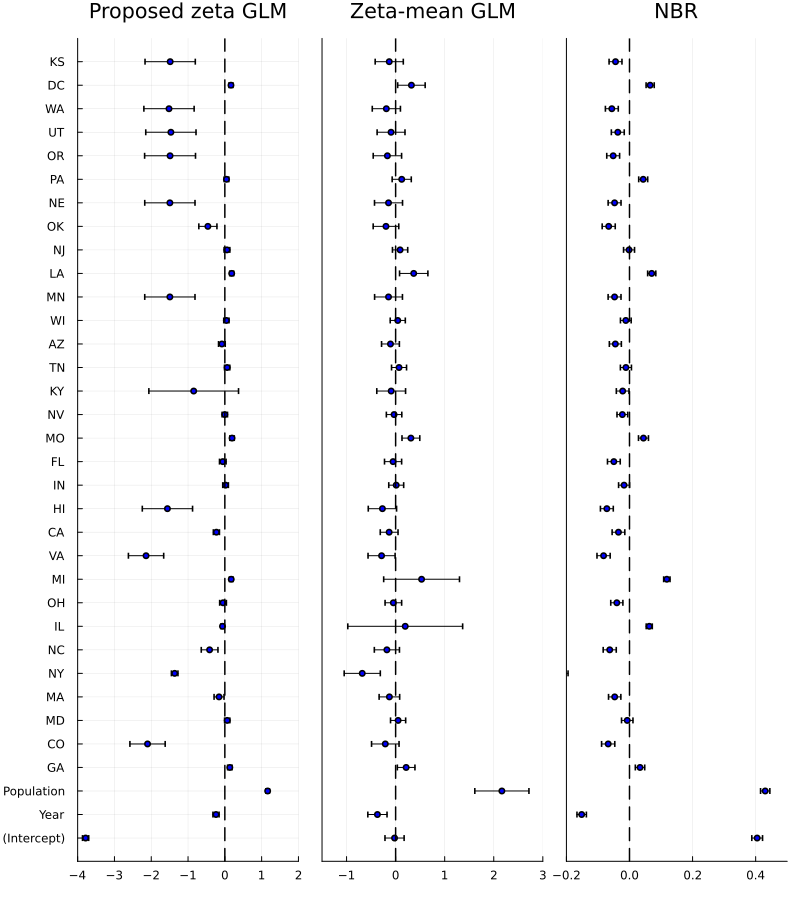

In [14]:
coefs = coef(gm)
se = stderror(gm)

lower = coefs .- 1.96 .* se
upper = coefs .+ 1.96 .* se
param_names = coefnames(gm)


bounds_str1 = df3[:, 5]
lower1, upper1 = Float64[], Float64[]

for s in bounds_str1
    m = match(r"\(\s*([-\d\.]+),\s*([-\d\.]+)\)", s)
    if m !== nothing
        push!(lower1, parse(Float64, m.captures[1]))
        push!(upper1, parse(Float64, m.captures[2]))
    else
        push!(lower1, NaN)
        push!(upper1, NaN)
    end
end

center1 = (lower1 .+ upper1) ./ 2
error1 = (upper1 .- lower1) ./ 2

x1 = 1:length(center1)
x1 = 2.0 .* x1
x2 = x1


# 第二个模型
bounds_str2 = df2[:, 5]
lower2, upper2 = Float64[], Float64[]

for s in bounds_str2
    m = match(r"\(\s*([-\d\.]+),\s*([-\d\.]+)\)", s)
    if m !== nothing
        push!(lower2, parse(Float64, m.captures[1]))
        push!(upper2, parse(Float64, m.captures[2]))
    else
        push!(lower2, NaN)
        push!(upper2, NaN)
    end
end

center2 = (lower2 .+ upper2) ./ 2
error2 = (upper2 .- lower2) ./ 2


using StatsPlots

# 创建绘图数据
y = collect(1:length(center1))
param_labels = param_names

# 反转顺序用于从上往下排列参数
center1_rev = center1
error1_rev = error1
center2_rev = center2
error2_rev = error2

plt1 = plot(center1_rev, y,
    xerror = error1_rev,
    seriestype = :scatter,
    markershape = :circle,
    yticks = (y, param_labels),
    title = "Proposed zeta GLM",
    legend = false,
    markersize = 3,
    color = :blue,
    xlim = (-4, 2))

vline!([0], linestyle = :dash, linewidth = 1.5, color = :black, label = "")

plt2 = plot(center2_rev, y,
    xerror = error2_rev,
    seriestype = :scatter,
    markershape = :circle,
    yticks = false, 
    title = "Zeta-mean GLM",
    legend = false,
    markersize = 3,
    color = :blue,
    xlim = (-1.5, 3))


vline!([0], linestyle = :dash, linewidth = 1.5, color = :black, label = "")


plt3 = plot(coefs, y,
    xerror = 1.96 .* se,
    seriestype = :scatter,
    markershape = :circle,
    yticks = false, 
    title = "NBR",
    legend = false,
    markersize = 3,
    color = :blue,
    xlim = (-0.2, 0.5))

vline!([0], linestyle = :dash, linewidth = 1.5, color = :black, label = "")

g = plot(plt1, plt2, plt3, layout = (1, 3), size = (800, 900))

# savefig(g, "/Users/caleblee/Downloads/zetacase2.pdf")


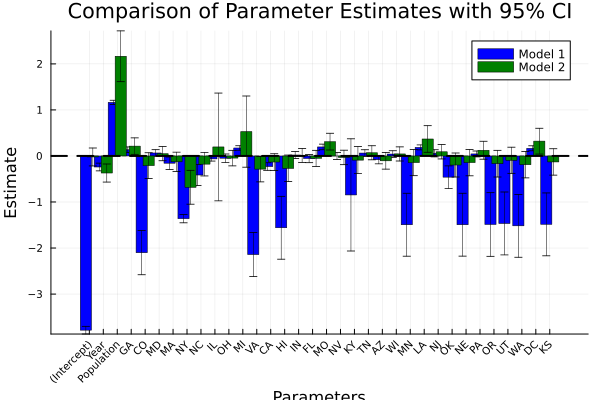

In [15]:
using Plots

x = 1:length(center1)
bar_width = 0.5

bar(x .- bar_width/2, center1,
    yerror = error1,
    label = "Model 1",
    width = bar_width,
    xticks = (x, param_names),
    legend = :topright,
    ylabel = "Estimate",
    xlabel = "Parameters",
    color = :blue,
    title = "Comparison of Parameter Estimates with 95% CI",
    tickfont = font(7),
    xrotation = 45)

bar!(x .+ bar_width/2, center2,
    yerror = error2,
    label = "Model 2",
    width = bar_width,
    color = :green)

hline!([0], color = :black, linestyle = :dash, linewidth = 2, label = "")



# Insurance data

In [16]:
Z = InsuranceData.num_insurances
X = InsuranceData.age

n = sum(Z)
s = 0
z = Vector{Float64}(undef, n)
W = ones(n,1)
for i in 1:size(Z)[1]
    for j in 1:size(Z)[2]
        zij = Z[Int(i),Int(j)]
        if zij>0
            z[(s+1):(s+zij)] .= i
            W[(s+1):(s+zij),1] .= X[Int(j)]
            s += zij
            s = Int(s)
        end
    end
end

Z = z
data = hcat(Z,W)
W = ZetaReg.StandardizeColumns(W)
data[:,2:end] = W
data = DataFrame(data, :auto)

rename!(data, [:x1, :x2] .=> [:insurance, :age])

2000×2 DataFrame
  Row │ insurance  age       
      │ Float64    Float64   
──────┼──────────────────────
    1 │       1.0  -1.97489
    2 │       1.0  -1.97489
    3 │       1.0  -1.97489
    4 │       1.0  -1.97489
    5 │       1.0  -1.97489
    6 │       1.0  -1.97489
    7 │       1.0  -1.97489
    8 │       1.0  -1.97489
    9 │       1.0  -1.97489
   10 │       1.0  -1.97489
   11 │       1.0  -1.97489
  ⋮   │     ⋮          ⋮
 1991 │       7.0   0.586576
 1992 │       8.0  -0.267247
 1993 │       8.0   0.586576
 1994 │       8.0   1.4404
 1995 │       9.0  -0.267247
 1996 │      10.0   0.586576
 1997 │      11.0  -0.267247
 1998 │      11.0  -0.267247
 1999 │      13.0   0.586576
 2000 │      17.0   1.4404
            1979 rows omitted

The 1 steps with infinity norm: 119.95236475132916 Log-likelihood: -1205.0046015614478
The 2 steps with infinity norm: 40.59987756787848 Log-likelihood: -1197.24672914557
The 3 steps with infinity norm: 1.9505894164784503 Log-likelihood: -1197.2347913883827
The 4 steps with infinity norm: 1.3151839966587127 Log-likelihood: -1197.2291428526512
The 5 steps with infinity norm: 0.5257760670106397 Log-likelihood: -1197.2284341448444
The 6 steps with infinity norm: 0.20020446702275851 Log-likelihood: -1197.2282455998532
The 7 steps with infinity norm: 0.1363451439971035 Log-likelihood: -1197.228186019372
The 8 steps with infinity norm: 0.07288361138402744 Log-likelihood: -1197.2281654765836
The 9 steps with infinity norm: 0.04430284451680233 Log-likelihood: -1197.228158508561
The 10 steps with infinity norm: 0.025562147809495173 Log-likelihood: -1197.2281561076747
The 11 steps with infinity norm: 0.015053591350745243 Log-likelihood: -1197.2281552871325
The 12 steps with infinity norm: 0.0087

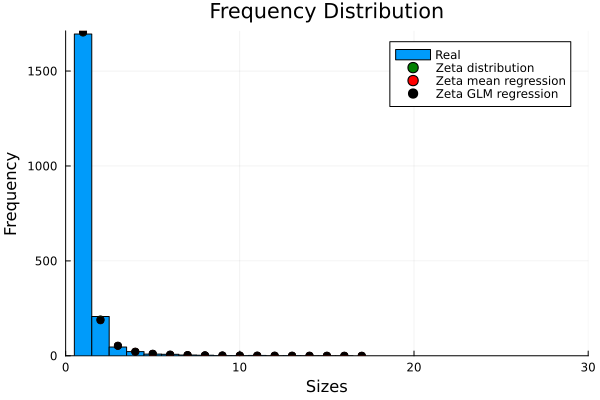

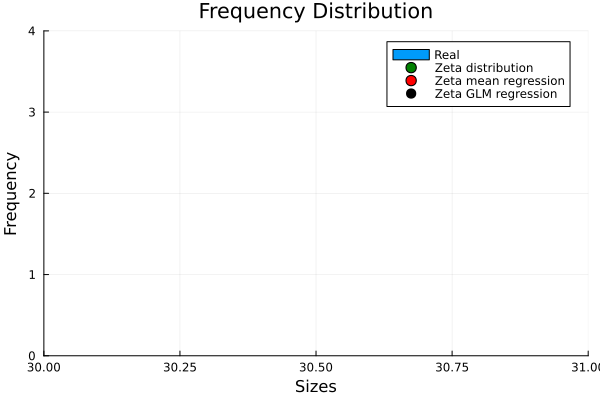

In [17]:

n = length(Z)
n0 = Int(maximum(Z))
x = range(1,n0,n0) 
θ0 = ZetaReg.Rootθ(sum(log.(Z))/n)
fit0 = (x.^(-θ0))./zeta(θ0) * n

LogLik0 = ZetaLogLik(θ0, log.(Z), 1)

(rho2, θ2, iters2, loglikelihoods2) = ZetaMeanModel(data, tol=1e-12, verbose=true)
(rho3, θ3, iters3, loglikelihoods3) = ZetaMeanLogModel(data, verbose=true)


println("θ0: ", θ0)
println("LogLik0: ", LogLik0)
println("LogLik2: ", loglikelihoods2[end], "Iterations: ",  iters2)
println("LogLik3: ", loglikelihoods3[end], "Iterations: ",  iters3)

x1 = range(1,n0,n0) 
fit2 = zeros(n0)
fit3 = zeros(n0)

for l in range(1, n, n)
    l = Int64(l)
    theta2 = θ2[l]
    fit2 = fit2 + (x1.^(-theta2))./zeta(theta2)
    theta3 = θ3[l]
    fit3 = fit3 + (x1.^(-theta3))./zeta(theta3)
end

p1 = plot()

histogram!(p1, Z, ylim = (0,max(fit0[1],fit2[1],fit3[1])+5), bins=0.5:(n0-0.5), xlim=(0, 30), label = "Real" , xlabel="Sizes", ylabel="Frequency", title="Frequency Distribution")
plot!(p1, x, fit0, label = "Zeta distribution", color = "green", seriestype=:scatter)
plot!(p1, x, fit2, label = "Zeta mean regression", color = "red", seriestype=:scatter)
plot!(p1, x, fit3, label = "Zeta GLM regression", color = "black", seriestype=:scatter)


display(p1)

# savefig(p1,"/Users/caleblee/Downloads/Zeta mean log reg/Frequency.pdf")

p2 = plot()
histogram!(p2, Z, ylim = (0,4), bins=0.5:(n0-0.5), xlim=(30, n0), label = "Real" , xlabel="Sizes", ylabel="Frequency", title="Frequency Distribution")
plot!(p2, x, fit0, label = "Zeta distribution", color = "green", seriestype=:scatter)
plot!(p2, x, fit2, label = "Zeta mean regression", color = "red", seriestype=:scatter)
plot!(p2, x, fit3, label = "Zeta GLM regression", color = "black", seriestype=:scatter)

display(p2)
# 

## Negativa Binomial Regression

In [18]:
using DataFrames, StatsModels, GLM, Distributions

data = hcat(Z, W)
data = DataFrame(data, :auto)

yvar = :x1
xvars = names(data)
deleteat!(xvars, findfirst(==(string(yvar)), xvars))  

fmla = Term(yvar) ~ sum(Term.(Symbol.(xvars)))       
gm = glm(fmla, data, NegativeBinomial(10000), LogLink())


gm_poisson = glm(fmla, data, Poisson(), LogLink())

println("Loglikelihood: ", loglikelihood(gm), "Loglikelihood: ", loglikelihood(gm_poisson))
gm

Loglikelihood: -2499.7259187899754Loglikelihood: -2499.688320342652


StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, NegativeBinomial{Float64}, LogLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int32}}}}, Matrix{Float64}}

x1 ~ 1 + x2

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      z  Pr(>|z|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  0.240616    0.0164551  14.62    <1e-47  0.208365    0.272868
x2           0.0736079   0.0162894   4.52    <1e-05  0.0416812   0.105535
─────────────────────────────────────────────────────────────────────────